# Perfilado y Limpieza de Datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import yaml

In [2]:
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

df = pd.read_csv("data.csv", encoding='latin1')

## Parte 1. Integración y Exploración

# 1. Carga e inspección

In [3]:
print("Shape del dataset:", df.shape)
print("\nTipos de datos:\n", df.dtypes)
print("\nPrimeras filas:")
display(df.head())

Shape del dataset: (541909, 8)

Tipos de datos:
 InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

Primeras filas:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### 2. Tipo de datos

In [4]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Variables numéricas y categóricas
num_cols = ['Quantity', 'UnitPrice']
cat_cols = ['InvoiceNo', 'StockCode', 'Description', 'Country', 'CustomerID']

# Verificación
print("\nResumen numéricas:")
display(df[num_cols].describe())
print("\nResumen categóricas:")
display(df[cat_cols].describe())


Resumen numéricas:


,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000



Resumen categóricas:


,CustomerID
count,406829.000000
mean,15287.690570
std,1713.600303
min,12346.000000
25%,13953.000000
50%,15152.000000
75%,16791.000000
max,18287.000000


### 3. Variables derivadas

In [5]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
print("\nColumna 'TotalPrice' creada.")
display(df[['Quantity', 'UnitPrice', 'TotalPrice']].head())


Columna 'TotalPrice' creada.


,Quantity,UnitPrice,TotalPrice
0,6,2.55,15.30
1,6,3.39,20.34
2,8,2.75,22.00
3,6,3.39,20.34
4,6,3.39,20.34


### 4. Distribuciones.

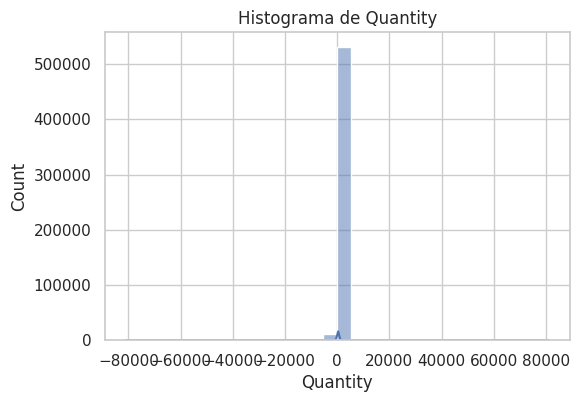

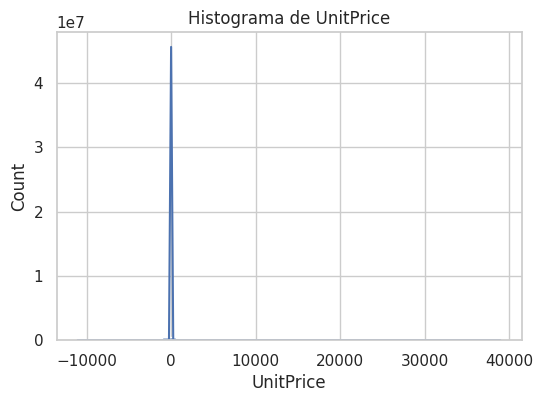

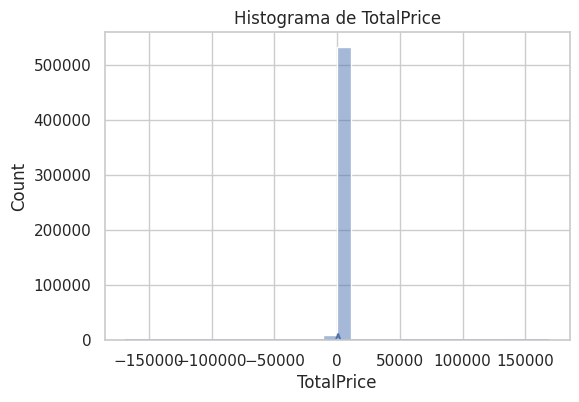

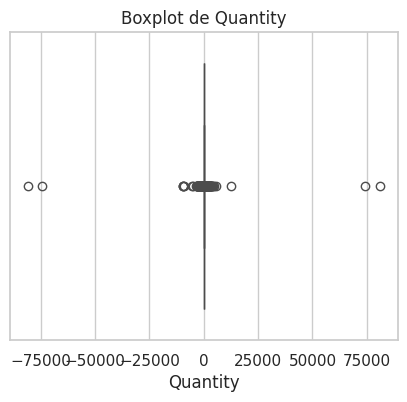

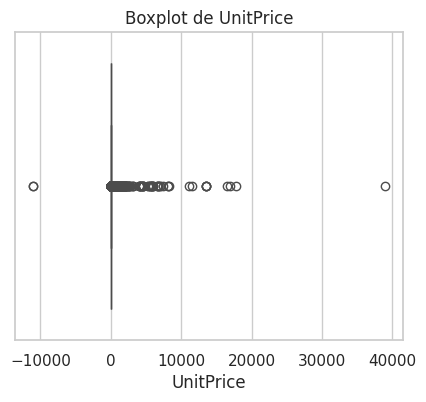

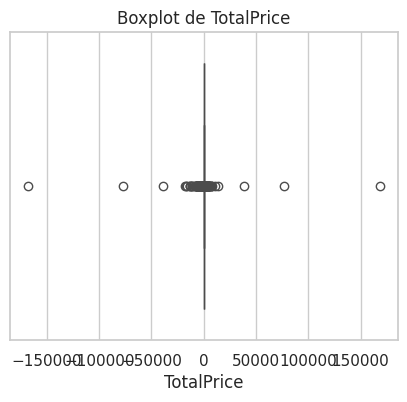

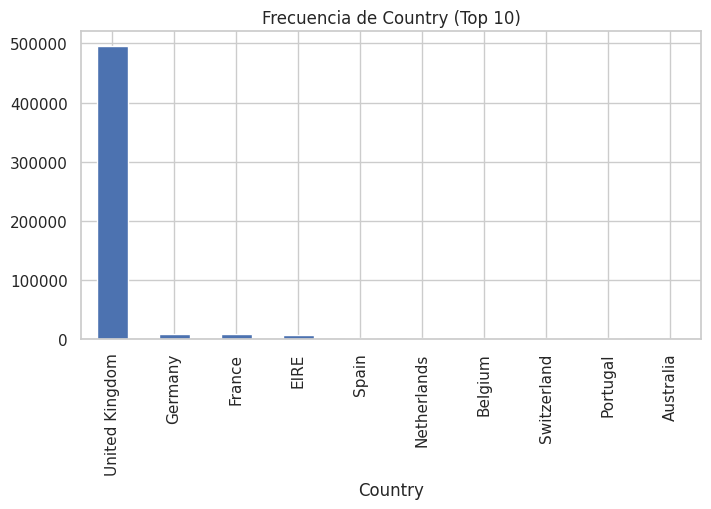

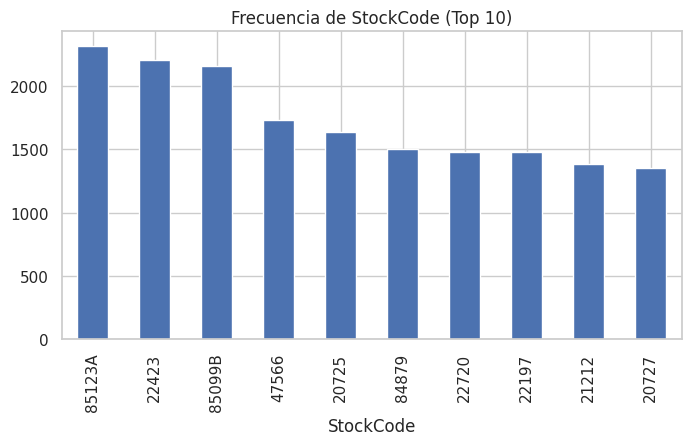

In [6]:
for col in num_cols + ['TotalPrice']:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col].dropna(), bins=30, kde=True)
    plt.title(f"Histograma de {col}")
    plt.show()

for col in num_cols + ['TotalPrice']:
    plt.figure(figsize=(5,4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de {col}")
    plt.show()

for col in ['Country', 'StockCode']:
    plt.figure(figsize=(8,4))
    df[col].value_counts().head(10).plot(kind='bar')
    plt.title(f"Frecuencia de {col} (Top 10)")
    plt.show()

## Parte 2. Perfilado de Calidad
# 1. Nulos (por columna)

In [7]:
nulls = df.isnull().mean() * 100
nulls_df = pd.DataFrame({'columna': nulls.index, 'porcentaje_nulos': nulls.values})
print("\nPorcentaje de nulos por columna:")
display(nulls_df.sort_values('porcentaje_nulos', ascending=False))


Porcentaje de nulos por columna:


,columna,porcentaje_nulos
6,CustomerID,24.926694
2,Description,0.268311
0,InvoiceNo,0.000000
3,Quantity,0.000000
1,StockCode,0.000000
4,InvoiceDate,0.000000
5,UnitPrice,0.000000
7,Country,0.000000
8,TotalPrice,0.000000


# 2. Duplicados

In [8]:
dup_exact = df.duplicated().sum()
print(f"\nDuplicados exactos: {dup_exact}")


Duplicados exactos: 5268


# 3. Valores anómalos (numéricas)

In [9]:
outlier_report = {}
for col in num_cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    outlier_report[col] = outliers
print("\nOutliers detectados (IQR):")
display(pd.DataFrame(outlier_report.items(), columns=["Columna", "Outliers"]))


Outliers detectados (IQR):


,Columna,Outliers
0,Quantity,58619
1,UnitPrice,39627


## Parte 3. Limpieza
# 1. Duplicados.

In [10]:
df_before = df.copy()

print("\nAntes de eliminar duplicados:", df.shape)
df = df.drop_duplicates()
print("Después de eliminar duplicados:", df.shape)


Antes de eliminar duplicados: (541909, 9)
Después de eliminar duplicados: (536641, 9)


## 2.	Valores faltantes (columna sugerida).

In [11]:
total_rows = df.shape[0]
rows_with_custid = df['CustomerID'].notnull().sum()
impact = 100 * (1 - rows_with_custid / total_rows)
print(f"\nImpacto de eliminar filas sin CustomerID: {impact:.2f}% del dataset")

df_clean = df.copy()


Impacto de eliminar filas sin CustomerID: 25.16% del dataset


## Parte 4. Data Contract

In [12]:
data_contract = {
    "dataset_name": "ecommerce_sales",
    "version": "1.0",
    "columns": {
        "InvoiceNo": {"type": "string", "nullable": False, "unique": False, "example": "536365"},
        "InvoiceDate": {"type": "datetime", "nullable": False, "format": "YYYY-MM-DD HH:MM:SS"},
        "StockCode": {"type": "string", "nullable": False},
        "Description": {"type": "string", "nullable": True},
        "Quantity": {"type": "integer", "nullable": False, "min": 1},
        "UnitPrice": {"type": "float", "nullable": False, "min": 0.0},
        "CustomerID": {"type": "float", "nullable": True},
    },
    "rules": {
        "TotalPrice": "Quantity * UnitPrice",
        "valid_country": "Country in ['United Kingdom', 'France', 'Germany', ...]"
    }
}

# Guardar como JSON y YAML
with open("data_contract.json", "w") as f:
    json.dump(data_contract, f, indent=4)
with open("data_contract.yaml", "w") as f:
    yaml.dump(data_contract, f, sort_keys=False)

print("\nData contract generado y guardado (JSON y YAML).")


Data contract generado y guardado (JSON y YAML).


## Parte 5. Conclusiones

In [13]:
summary = pd.DataFrame({
    "Métrica": ["Filas originales", "Duplicados eliminados", "Filas finales", "Columnas totales"],
    "Valor": [df_before.shape[0],
              df_before.shape[0] - df.shape[0],
              df_clean.shape[0],
              df_clean.shape[1]]
})
print("\nResumen del proceso de limpieza:")
display(summary)


Resumen del proceso de limpieza:


,Métrica,Valor
0,Filas originales,541909
1,Duplicados eliminados,5268
2,Filas finales,536641
3,Columnas totales,9
